In [195]:
import pickle

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from cmocean import cm as cmo
from utils import *
from IPython.display import HTML, display
from tqdm import tqdm

In [4]:
# Graphic settings
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Addtn'l settings
tqdm.monitor_interval = 0

In [157]:
# Some useful definitions

class PyMCModel:
    def __init__(self, model, model_name='None'):
        self.model = model
        self.model.name = model_name
        
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

    
def ridge_regression(X, y_obs, ylabel='y'):
    with pm.Model() as mridge:
        sd_beta = pm.HalfCauchy('sd_beta', beta=10)
        sig = pm.HalfCauchy('sigma', beta=10)
        w = pm.Normal('w', mu=0, sd=sd_beta, shape=X.shape[1])
        mu_ = pm.Deterministic('mu', tt.dot(X, w))
        y = pm.Normal(ylabel, mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mridge


def lasso_regression(X, y_obs, ylabel='y'):
    with pm.Model() as mlasso:
        sd_beta = pm.HalfCauchy('sd_beta', beta=10)
        sig = pm.HalfCauchy('sigma', beta=10)
        w = pm.Laplace('w', mu=0, b=sd_beta, shape=X.shape[1])
        mu_ = pm.Deterministic('mu', tt.dot(X, w))
        y = pm.Normal('y', mu=mu_, sd=sig, observed=y_obs.squeeze())
    return mlasso

In [5]:
# Fitting with PC from band-wise normalized then standardized rrs_rc
df_pca = pd.read_pickle('./pickleJar/df_4_pca3_frombwnorm.pkl')
df_chl = pd.read_pickle('./pickleJar/df_4_ML4chl.pkl')

In [6]:
df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 16 columns):
oisst            495 non-null float64
etopo2           495 non-null float64
solz             495 non-null float64
sat_rho_rc412    495 non-null float64
sat_rho_rc443    495 non-null float64
sat_rho_rc490    495 non-null float64
sat_rho_rc510    495 non-null float64
sat_rho_rc555    495 non-null float64
sat_rho_rc670    495 non-null float64
datetime         495 non-null datetime64[ns]
lat              495 non-null float64
lon              495 non-null float64
chl_fluo         364 non-null float64
chl_hplc         158 non-null float64
chl              424 non-null float64
is_hplc          495 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(14)
memory usage: 62.4 KB


In [7]:
df_chl['log10_chl'] = np.log10(df_chl.chl)

In [8]:
df = pd.concat((df_pca, df_chl[['log10_chl']]), axis=1)

In [9]:
df.shape

(495, 7)

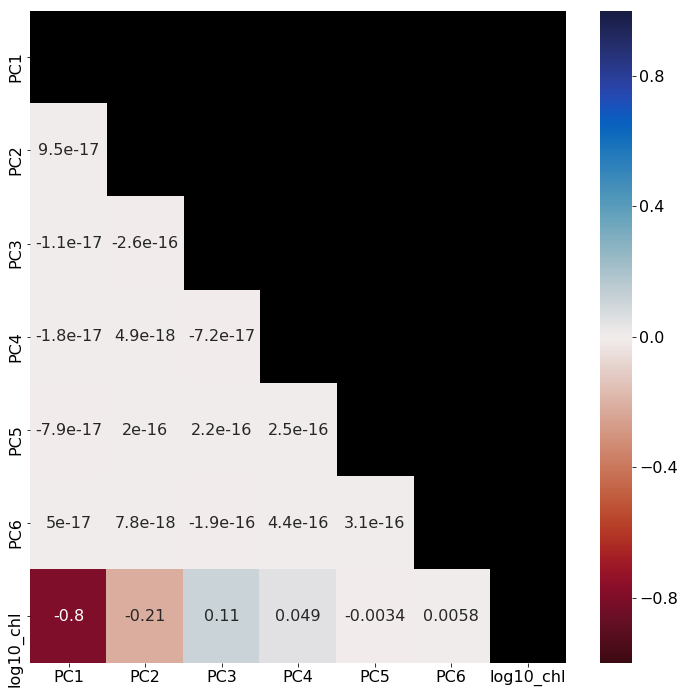

In [16]:
_, ax = pl.subplots(figsize=(12, 12))
ax.set_facecolor('k')
heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmo.balance_r,
       mask=np.triu(np.ones([df.shape[1]]*2)));

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


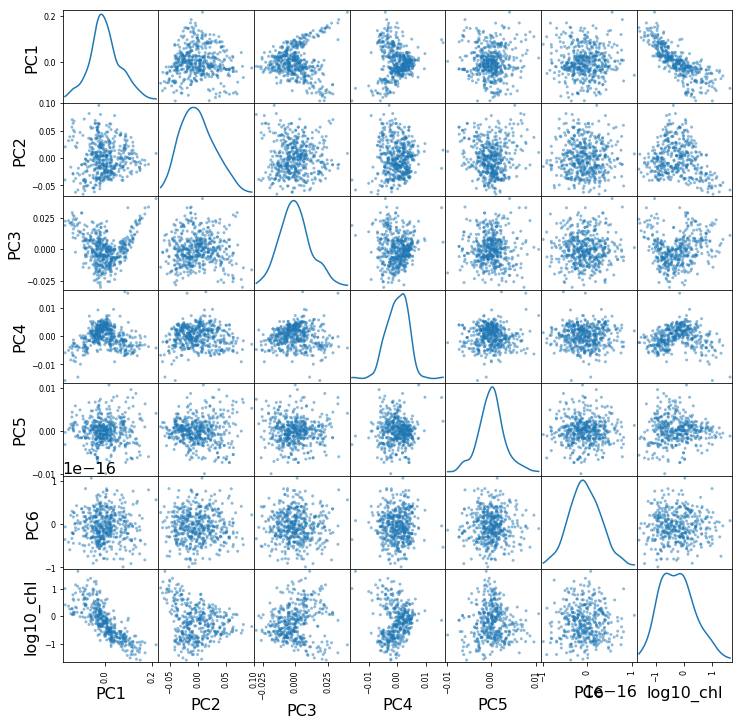

In [11]:
_, ax = pl.subplots(figsize=(12, 12))
scatter_matrix(df, diagonal='kde', ax=ax);

In [75]:
X = df.dropna().filter(regex='PC').values
y = df.dropna().log10_chl.values.reshape(-1, 1)
polymaker = PolynomialFeatures(interaction_only=True, include_bias=True)

In [149]:
Xpoly = polymaker.fit_transform(X)

In [150]:
x_scaler = StandardScaler()
xp_scaler = StandardScaler()
y_scaler = StandardScaler()
X_s = x_scaler.fit_transform(X)
X_s = np.c_[np.ones(X_s.shape[0]), X_s]       
Xp_s = xp_scaler.fit_transform(Xpoly[:, 1:])
Xp_s = np.c_[np.ones(Xp_s.shape[0]), Xp_s]
y_s = y_scaler.fit_transform(y)

In [151]:
d = pd.DataFrame(np.c_[X_s[:, 1:], y_s], columns=['%s_s' %col for col in df.columns])

In [152]:
col_names = polymaker.get_feature_names(input_features=d.columns.tolist())[1:] + ['log10_chl_s']
dpoly = pd.DataFrame(np.c_[Xp_s[:, 1:], y_s], columns=col_names)

In [153]:
dpoly.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1_s,423.0,1.175839e-16,1.001184,-2.577203,-0.584940,-0.035728,0.567510,3.206132
PC2_s,423.0,1.034108e-16,1.001184,-2.127828,-0.761234,-0.088144,0.683952,3.245698
PC3_s,423.0,-2.099713e-17,1.001184,-2.497398,-0.663837,-0.059507,0.592627,3.394904
PC4_s,423.0,-2.687632e-16,1.001184,-4.381859,-0.647002,0.055625,0.738964,4.478480
PC5_s,423.0,-1.679770e-17,1.001184,-3.456160,-0.615838,-0.023539,0.521080,3.561673
PC6_s,423.0,-1.658773e-16,1.001184,-2.769202,-0.686497,-0.022058,0.667799,3.296377
PC1_s PC2_s,423.0,-6.194152e-17,1.001184,-4.871948,-0.344831,-0.019080,0.393002,3.859902
PC1_s PC3_s,423.0,3.779483e-17,1.001184,-3.516681,-0.235002,-0.006360,0.189468,7.615814
PC1_s PC4_s,423.0,0.000000e+00,1.001184,-3.018102,-0.246508,-0.042313,0.136394,8.442768
PC1_s PC5_s,423.0,-2.309684e-17,1.001184,-3.860633,-0.273982,0.009689,0.229791,5.264605


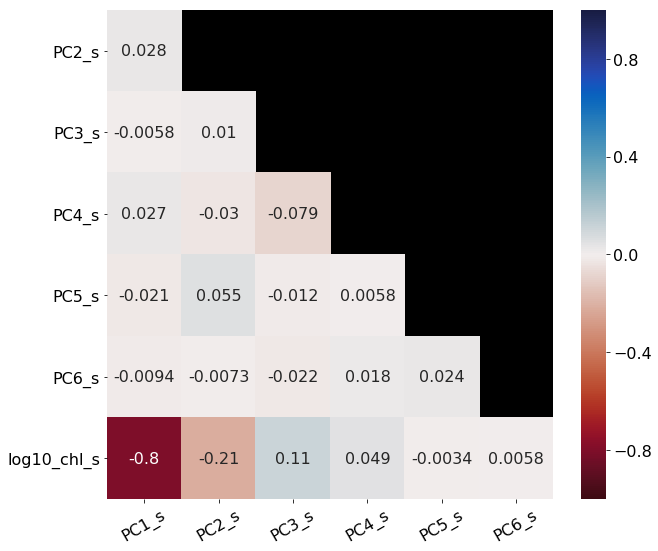

In [128]:
_, ax = pl.subplots(figsize=(10, 9))
ax.set_facecolor('black')
heatmap(d.corr().iloc[1:, :-1], vmin=-1, vmax=1, annot=True,
       mask=np.triu(np.ones((6,6)), k=1), ax=ax, cmap=cmo.balance_r);
ax.tick_params(axis='x', rotation=30)

In [129]:
d.describe()

,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,log10_chl_s
count,423.000000,4.230000e+02,4.230000e+02,423.000000,4.230000e+02,4.230000e+02,4.230000e+02
mean,0.000000,2.309684e-17,-2.099713e-18,0.000000,-6.719080e-17,1.784756e-17,-6.719080e-17
std,1.001184,1.001184e+00,1.001184e+00,1.001184,1.001184e+00,1.001184e+00,1.001184e+00
min,-2.577203,-2.127828e+00,-2.497398e+00,-4.381859,-3.456160e+00,-2.769202e+00,-2.251640e+00
25%,-0.584940,-7.612339e-01,-6.638373e-01,-0.647002,-6.158380e-01,-6.864971e-01,-7.626179e-01
50%,-0.035728,-8.814362e-02,-5.950736e-02,0.055625,-2.353864e-02,-2.205774e-02,-5.138531e-02
75%,0.567510,6.839522e-01,5.926271e-01,0.738964,5.210802e-01,6.677994e-01,6.293800e-01
max,3.206132,3.245698e+00,3.394904e+00,4.478480,3.561673e+00,3.296377e+00,3.099647e+00


In [130]:
d.head()

,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s,log10_chl_s
0,0.351266,-0.762884,-0.737736,0.330311,-1.037654,0.594934,-1.323915
1,0.870624,-0.610153,-0.802267,-0.638707,-1.264113,0.514432,-1.137345
2,1.014308,0.496331,0.088608,1.015205,-0.268243,1.265004,0.046962
3,1.548007,0.031205,0.608765,0.133692,-0.416693,-1.694552,-0.927735
4,-1.277924,-0.002770,-0.329040,0.137882,-0.648940,0.028175,1.093276


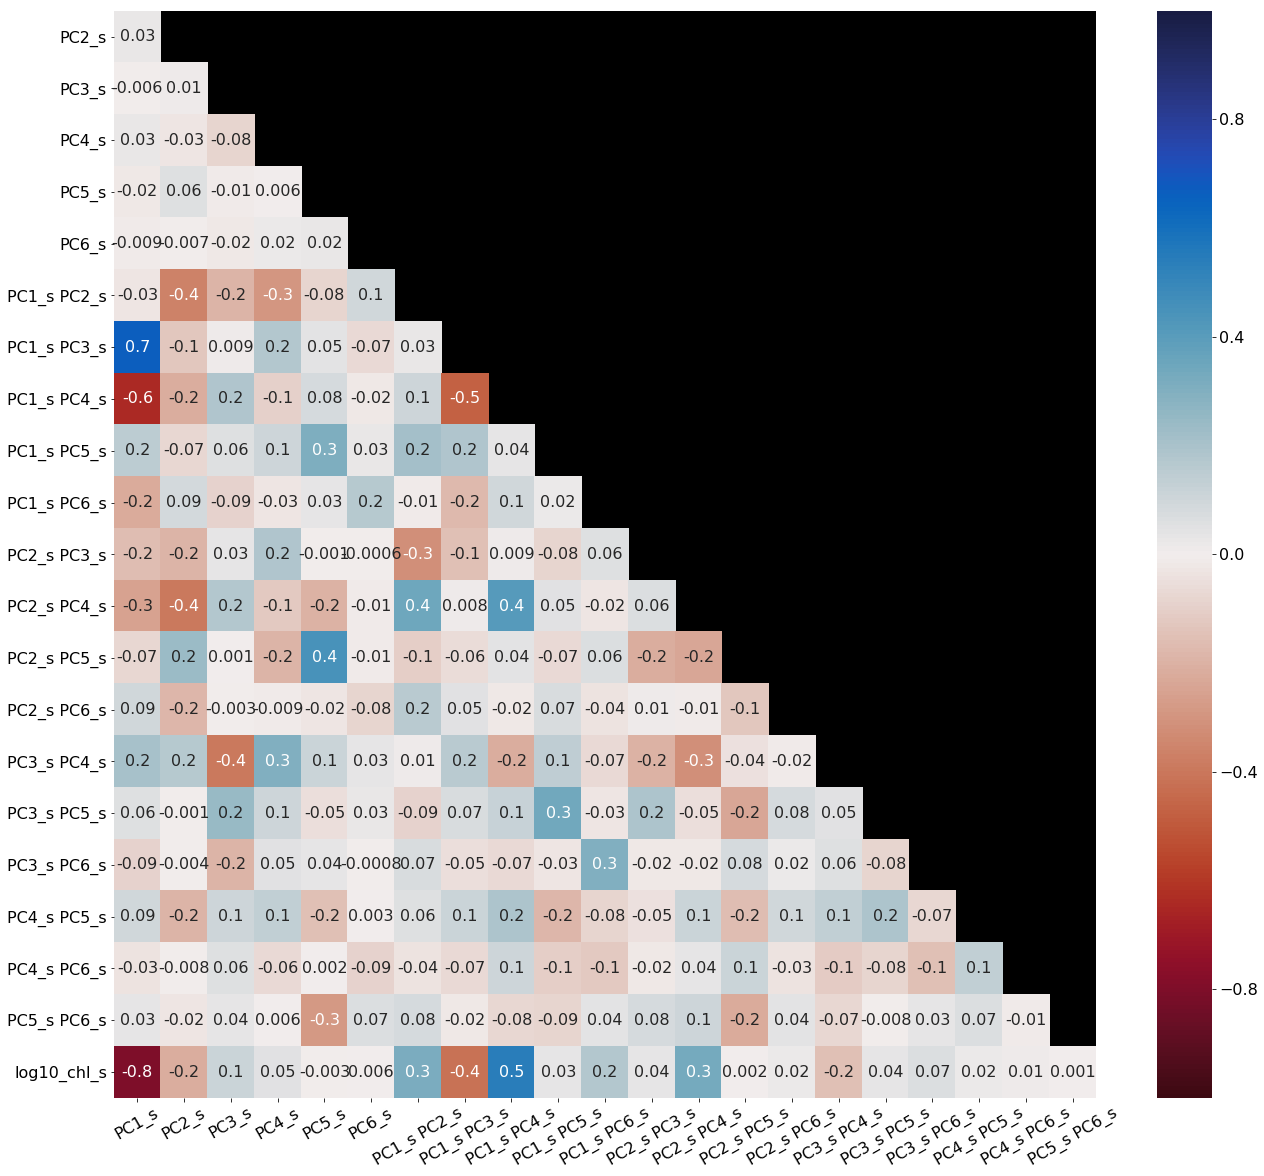

In [154]:
_, ax = pl.subplots(figsize=(22, 20))
ax.set_facecolor('black')
heatmap(dpoly.corr().iloc[1:, :-1], vmin=-1, vmax=1, annot=True, fmt='.1g',
       mask=np.triu(np.ones([dpoly.shape[1]-1]*2), k=1), ax=ax, cmap=cmo.balance_r);
ax.tick_params(axis='x', rotation=30)

## <u>Fitting:</u>

In [111]:
predictors = d.filter(regex='PC')
predicted = d.log10_chl_s

### Ridge regression on PC1-6
<br>
'w [x]' are weights where x is an integer corresponding the a PC if x>0; to the bias, otherwise.

In [140]:
m0_ridge = ridge_regression(X_s, y_s, ylabel='log10_chl')

In [135]:
with m0_ridge:
    t0_ridge = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__, sd_beta_log__]
100%|██████████| 2500/2500 [00:03<00:00, 803.50it/s]


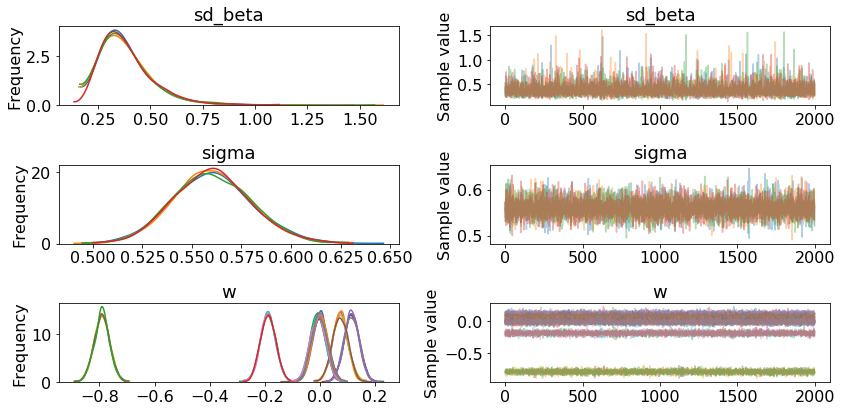

In [137]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(t0_ridge, varnames=vars_);

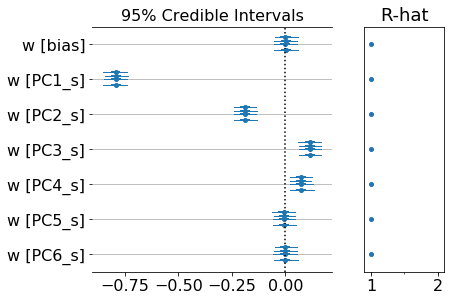

In [188]:
lbls = ['bias'] + d.columns.tolist()[:-1]
lbls_list = ['w [%s]' % lbl for lbl in lbls]
pm.forestplot(t0_ridge, varnames='w', ylabels=lbls_list);
f = pl.gcf()
a = f.get_axes()[1]
a.grid(axis='y')

### Lasso Regression on PC1-6

In [158]:
m0_lasso = lasso_regression(X_s, y_s, ylabel='log10_chl')

In [159]:
with m0_lasso:
    t0_lasso = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__, sd_beta_log__]
100%|██████████| 2500/2500 [00:03<00:00, 808.97it/s]


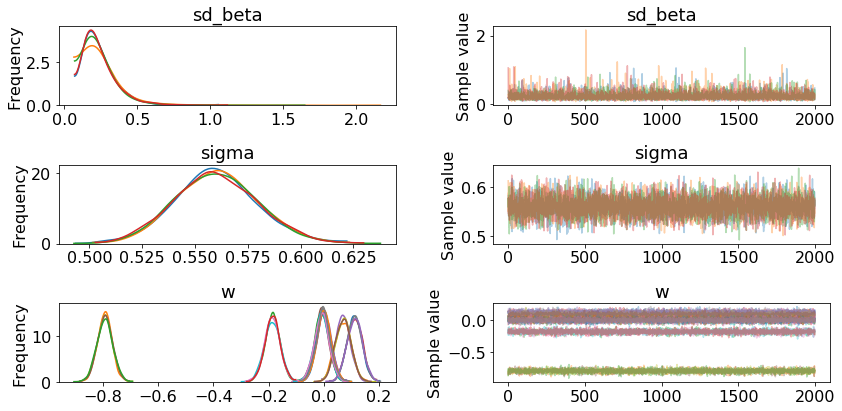

In [160]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(t0_lasso, varnames=vars_);

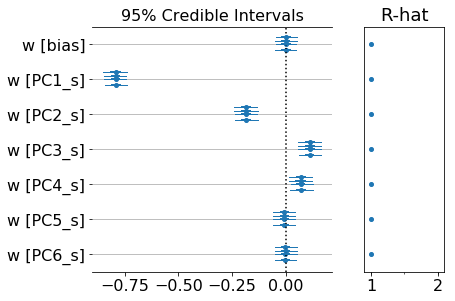

In [187]:
pm.forestplot(t0_lasso, varnames='w', ylabels=lbls_list);
f = pl.gcf()
a = f.get_axes()[1]
a.grid(axis='y')

### Ridge Regression on PC1-6 and interactions

In [162]:
m1_ridge = ridge_regression(Xp_s, y_s, ylabel='log10_chl')

In [163]:
with m1_ridge:
    t1_ridge = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__, sd_beta_log__]
100%|██████████| 2500/2500 [03:42<00:00, 11.24it/s]


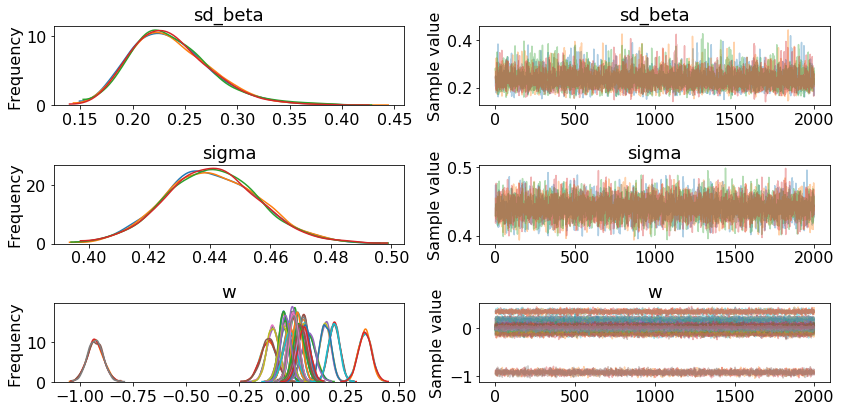

In [164]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(t1_ridge, varnames=vars_);

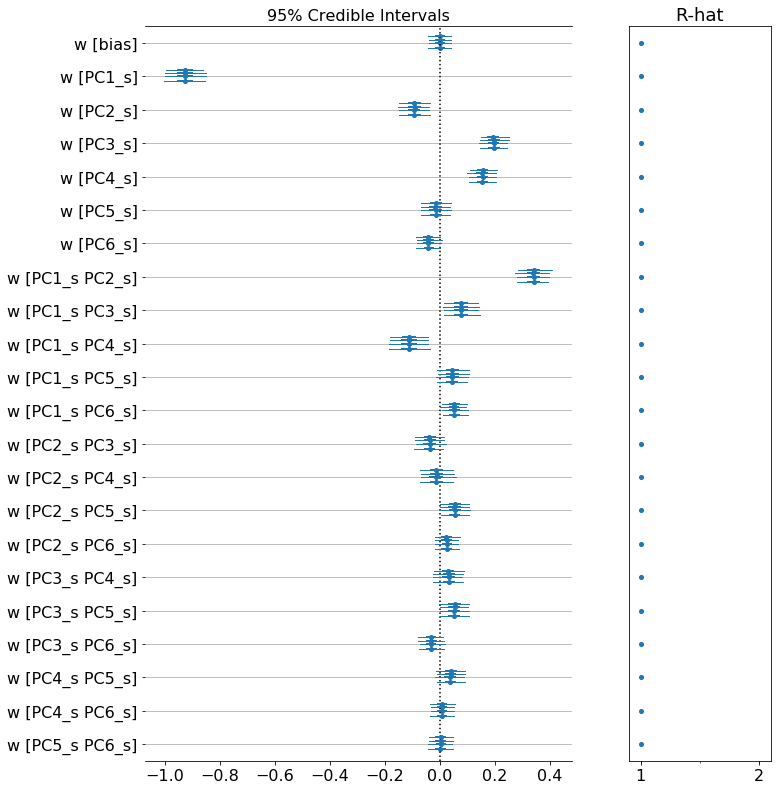

In [186]:
labels_list = ['bias'] + dpoly.columns.tolist()[:-1]
g = pm.forestplot(t1_ridge, varnames='w', ylabels=['w [%s]' %lbl for lbl in labels_list])
f = pl.gcf()
f.set_figheight(12)
f.set_figwidth(12)
a = f.get_axes()[1]
a.grid(axis='y')

In [189]:
m1_lasso = lasso_regression(Xp_s, y_s, ylabel='log10_chl')

In [190]:
with m1_lasso:
    t1_lasso = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma_log__, sd_beta_log__]
100%|██████████| 2500/2500 [03:45<00:00, 11.11it/s]


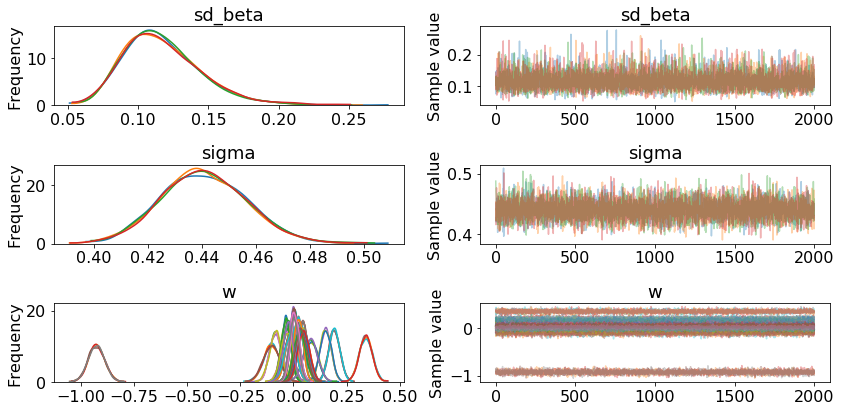

In [191]:
vars_ = ['sd_beta', 'sigma', 'w']
pm.traceplot(t1_lasso, varnames=vars_);

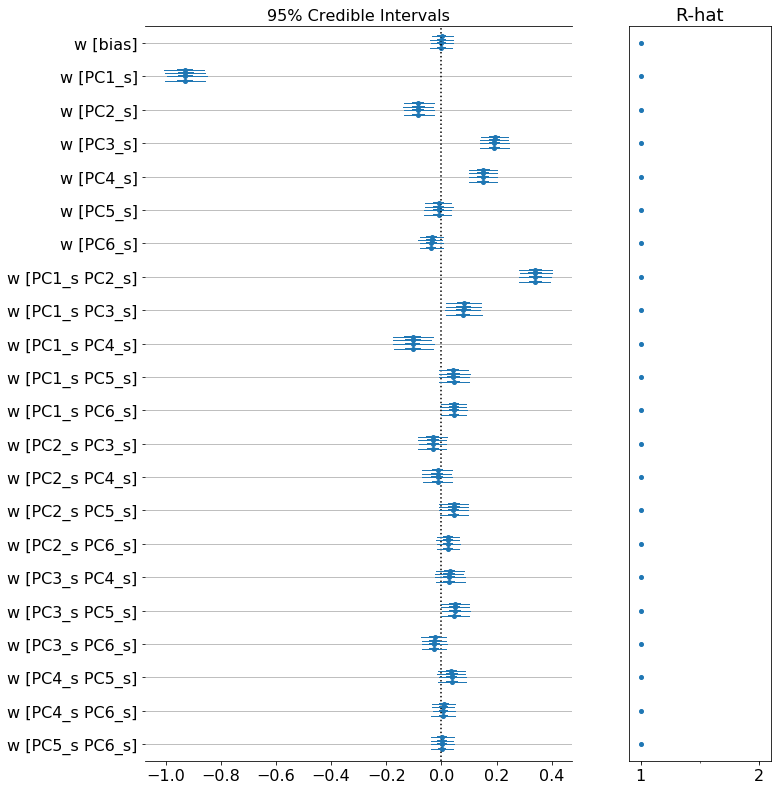

In [194]:
pm.forestplot(t1_lasso, varnames='w', ylabels=['w [%s]' % lbl for lbl in labels_list])
f = pl.gcf()
f.set_figheight(12)
f.set_figwidth(12)
a = f.get_axes()[1]
a.grid(axis='y')

In [197]:
# pickle models and model results
m0_lasso.name = 'lasso_pc1_6'
m0_ridge.name = 'ridge_pc1_6'
m1_lasso.name = 'lasso_pc1_6_interactions'
m1_ridge.name = 'ridge_pc1_6_interactions'
model_dict = {m0_lasso.name: dict(model=m0_lasso, trace=t0_lasso),
              m1_lasso.name: dict(model=m1_lasso, trace=t1_lasso),
              m0_ridge.name: dict(model=m0_ridge, trace=t0_ridge),
              m1_ridge.name: dict(model=m1_ridge, trace=t1_ridge),
             }
with open('./pickleJar/ridge_lasso_model_fits.pkl', 'wb') as f:
    pickle.dump(model_dict, f)

### <u>Model Evaluation:</u>

In [146]:
mu_log10chl_s = y_scaler.inverse_transform(t0_ridge.get_values('mu'))

In [147]:
mu_log10chl_mean_s = np.median(mu_log10chl_s, axis=0)
mu_log10chl_mean_r = y_scaler.inverse_transform(mu_log10chl_mean_s)
mu_hpd_s = pm.hpd(mu_log10chl_s)
mu_hpd_r = y_scaler.inverse_transform(mu_hpd_s)

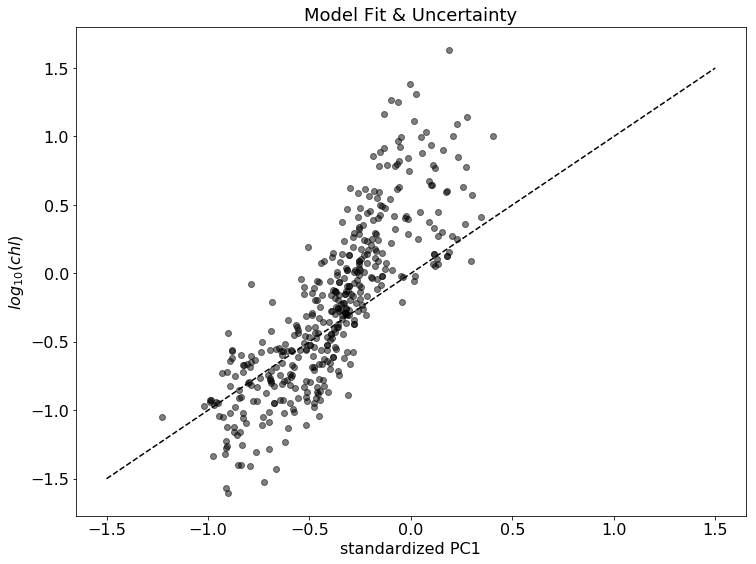

In [148]:
f, ax = pl.subplots(figsize=(12, 9))
ax.set_title('Model Fit & Uncertainty')
ax.set_xlabel('standardized PC1')
ax.set_ylabel('$log_{10}(chl)$')
ax.scatter(mu_log10chl_mean_r, y, color='k', label='Obs', alpha=0.5);
ax.plot([-1.5, 1.5], [-1.5, 1.5], 'k--')
#ax.scatter(pc1_x[ix], mu_log10chl_mean_r[ix], color='m', label='Model mean', alpha=0.5)

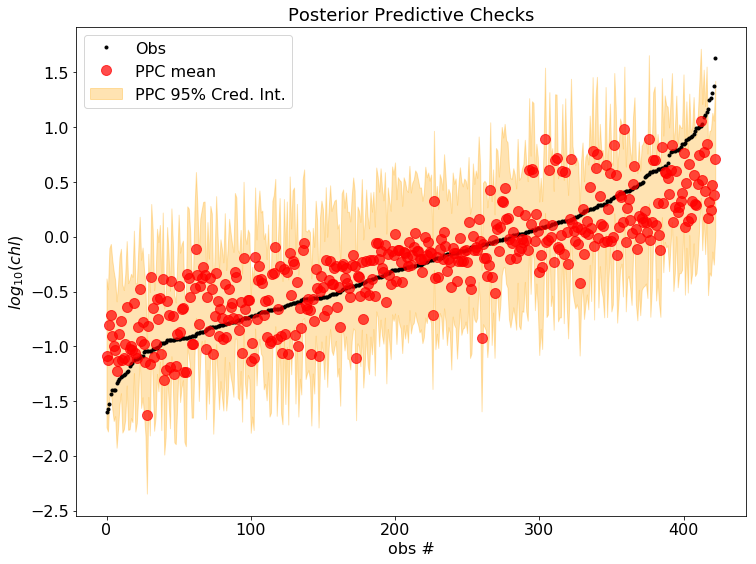

In [171]:
f, ax = pl.subplots(figsize=(12, 9))
ax.set_title('Posterior Predictive Checks')
ax.set_xlabel('obs #')
ax.set_ylabel('$log_{10}(chl)$')
ax.plot(y.ravel()[ix], ls='', marker='.', color='k', label='Obs')
ax.plot(mn_r[ix], ls='', color='r', marker='o', markersize=10, alpha=0.7, label='PPC mean')
ax.fill_between(xi, hpd_r[ix, 0], hpd_r[ix, 1], color='orange', alpha=0.3, label='PPC 95% Cred. Int.');
ax.legend(loc='best');